In [ ]:
! pip install numba
import numba
from numba import cuda
from numba.cuda.cudadrv import enums
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from numba import vectorize
import math

from google.colab import drive
drive.mount("/content/drive/")

params = {
    'figure.figsize': [15, 10],  # instead of 4.5, 4.5
    'axes.titlesize': 15,
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'font.size': 20,
    'font.family': 'monospace',
    #    'font.monospace': 'Alma Mono',
    'legend.fontsize': 15,
    'legend.loc': 'upper right',
    'legend.labelspacing': 0.25,
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    'lines.linewidth': 3,
    'text.usetex': False,
    # 'figure.autolayout': True,
    'ytick.right': False,
    'xtick.top': False,

    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,

    'xtick.major.pad': 2,
    'ytick.major.pad': 2,
    # 'xtick.minor.pad': 14,
    # 'ytick.minor.pad': 14,

    'xtick.direction': 'inout',
    'ytick.direction': 'inout',

    'grid.linestyle': '-',         # solid
    'grid.linewidth': 1.5,        # in points
    'grid.alpha':     1,        # transparency, between 0.0 and 1.0
}
# plt.style.use('fivethirtyeight')
matplotlib.rcParams.update(params)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from numba.parfors.parfor import maximize_fusion_inner
#LABWORK8 - RGB to HSV

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.jpg"
Image_path_2=Data_path+"Test_org.jpg"
# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid


# RGB to HSV
@cuda.jit
def scale_rgb_hsv(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  r = float(src[tidx,tidy,0] / 255)
  g = float(src[tidx,tidy,1] / 255)
  b = float(src[tidx,tidy,2] / 255)
  max_color=max(r,g,b)
  min_color=min(r,g,b)
  delta = max_color - min_color

  # Hue

  #0 must be float to match with delta
  if delta == np.float64(0):
    h = 0
  elif max_color == r:
    h = float(60*(((g-b)/delta) %6))
  elif max_color == g:
    h = float(60*((b-r)/delta + 2))
  else:
    h = float(60*((r-g)/delta + 4))

  # saturation
  if max_color != 0:
    s = np.float32(delta/max_color)
  else:
    s = 0

  dst[tidx,tidy,0] = h
  dst[tidx,tidy,1] = s
  dst[tidx,tidy,2] = max_color

#HSV to RGB
@cuda.jit
def scale_hsv_rgb(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  h = src[tidx,tidy,0]
  s = src[tidx,tidy,1]
  v = src[tidx,tidy,2]

  d = float(h/60)
  hi = int(d%6)
  f = float(d - hi)
  l = float(v * (1-s))
  m = float(v * (1-f*s))
  n = float(v * (1 - (1-f)*s))

  if np.float64(0) <= h < np.float64(60):
    r = v
    g = n
    b = l
  elif np.float64(60) <= h < np.float64(120):
    r = m
    g = v
    b = l
  elif np.float64(120) <= h < np.float64(180):
    r = l
    g = v
    b = n
  elif np.float64(180) <= h < np.float64(240):
    r = l
    g = m
    b = v
  elif np.float64(240) <= h < np.float64(300):
    r = n
    g = l
    b = v
  else:
    r = v
    g = l
    b = m
  cuda.syncthreads()

  dst[tidx,tidy,0] = r * 255
  dst[tidx,tidy,1] = g * 255
  dst[tidx,tidy,2] = b * 255
  cuda.syncthreads()

# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
out_img = np.array(img_data, copy=True)


def compare(blockSize, option, colorspace = "rgb", img = img_data):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)
  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img)


  if colorspace == "rgb":
      # Allocate memory on the device (GPU)
    devDst = cuda.device_array((imageHeight,imageWidth,3), np.float32)
  # Reduce finding max, min
    scale_rgb_hsv[gridSize,blockSize](devSrc, devDst)
  else:
      # Allocate memory on the device (GPU)
    devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)
    scale_hsv_rgb[gridSize,blockSize](devSrc, devDst)

  # Copy from device to host
  hostDst=devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if option == True:
    return run_time, hostDst
  else: return run_time



37 60
37 60
[[[ 7 13 30]
  [ 6 11 28]
  [ 6 11 28]
  ...
  [10 15 32]
  [ 9 15 34]
  [ 8 14 33]]

 [[ 9 14 31]
  [ 7 13 30]
  [ 7 12 29]
  ...
  [12 15 32]
  [10 14 33]
  [10 13 32]]

 [[ 9 14 31]
  [ 7 13 30]
  [ 7 13 30]
  ...
  [12 15 32]
  [11 14 31]
  [ 8 11 29]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
The run time is 0.44664669036865234 s


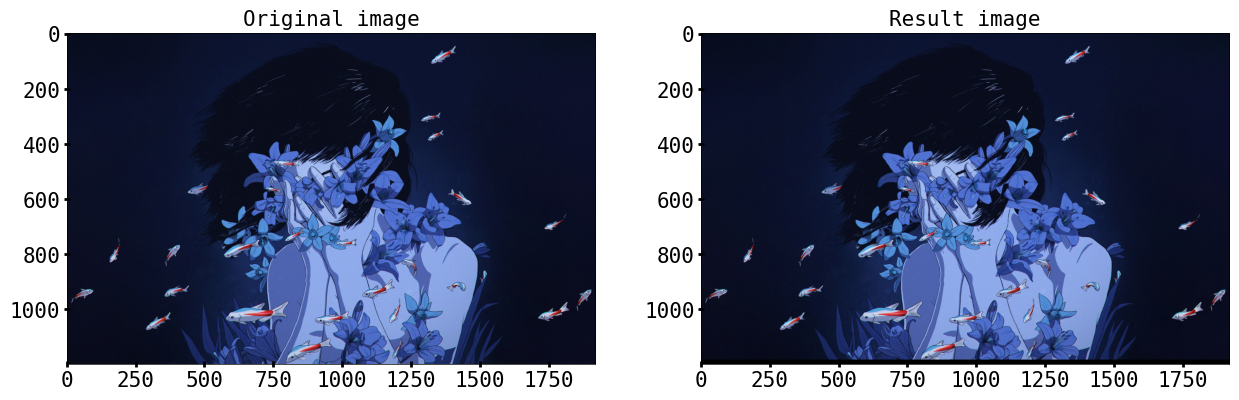

In [ ]:
#Output run_time and hostDst

plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img_data)

blockSize = 32
run_time_1, hsvDst= compare(blockSize,option=True)
run_time_2, rgbDst= compare(blockSize, option=True, colorspace = "hsv", img = hsvDst)

print(rgbDst)
plt.subplot(1,2,2)
# Show the resule image
plt.title("Result image")
plt.imshow(rgbDst)

# Save the image
plt.savefig(Data_path+"Test_result_LW8_rgb.jpg")
print("The run time is",run_time_2,"s")